<a href="https://colab.research.google.com/github/AlviNabil/ImageProcessingColab/blob/main/lab1/ImageLabAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing Libraries

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 


#Loading the image from the drive. (Taking a small image(128*128) as doubly toeplitz matrix takes a lot of space in memory)
For a 256x256 image it would take around 32 GigaByte space in memory

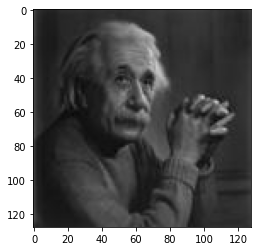

In [4]:
path = '/content/drive/MyDrive/4_1/ImageLab/Lab1/ein128.jpg'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#Declaring the kernel(Filter)

In [5]:
kernel = np.array(([0,-1,0],
                   [-1,5,-1],
                   [0,-1,0]),
                  np.float32)
kernel_H = kernel.shape[0]
H = (kernel_H-1)//2
kernel_W = kernel.shape[1]
W = (kernel_W-1)//2

#Adding padding in our image

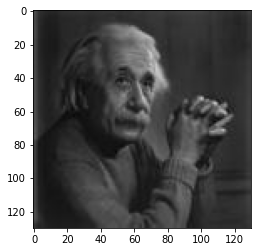

In [6]:
padImage = cv2.copyMakeBorder(img,H,H,W,W,cv2.BORDER_REPLICATE)
plt.imshow(cv2.cvtColor(padImage, cv2.COLOR_BGR2RGB))
plt.show()

#Taking Row and Column Count of input image and kernel

In [7]:
I_row_num, I_col_num = img.shape
F_row_num, F_col_num = kernel.shape


#Output Dimension
output_row = image_row + kernel_row - 1,
output_col = image_col + kernel_col - 1
(for full convolution)

In [8]:
output_row_num = I_row_num + F_row_num - 1
output_col_num = I_col_num + F_col_num - 1
output_shape = output_row_num, output_col_num
print(output_row_num, output_col_num)

130 130


#Zero Padding the filter to make the size of the filter same as output

In [21]:
F_zero_padded = np.pad(kernel, ((output_row_num-F_row_num, 0),
                                (0,output_col_num-F_col_num)),
                       'constant', constant_values = 0)
print(F_zero_padded)


[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0. -1.  0. ...  0.  0.  0.]
 [-1.  5. -1. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]]


The column of these generated toepliitz matrices should be same as the number of columns of the input of the input(img) 

In [23]:
#importing additional library for toeplitz function
import scipy.linalg as sl
toeplitz_list = []
for i in range(F_zero_padded.shape[0]-1, -1,-1):#iterating from last row to first (as our image will be flipped upside down)
  c = F_zero_padded[i,:];#taking the i'th row 
  r = np.r_[c[0], np.zeros(I_col_num-1)] #concatening two array quickly (Translates slice objects to concatenation along the first axis)
  toeplitz_m = sl.toeplitz(c,r)#createing toeplitz matrices for each row
  toeplitz_list.append(toeplitz_m)
  
  

#Doubly Block Creation

In [36]:
c = range(1, F_zero_padded.shape[0]+1)
r = np.r_[c[0], np.zeros(img.shape[0]-1, dtype=int)]#number of column in this symbolic doubly blocked toeplitz should be equal to the number of row in the input signal
doubly_indices = sl.toeplitz(c,r)
print(doubly_indices)

[[  1   0   0 ...   0   0   0]
 [  2   1   0 ...   0   0   0]
 [  3   2   1 ...   0   0   0]
 ...
 [128 127 126 ...   3   2   1]
 [129 128 127 ...   4   3   2]
 [130 129 128 ...   5   4   3]]


#Calculating the size of the doubly_blocked matrices from doubly indices and the size of toeplitz matrix for each row of zero_padded_kernel

In [37]:
#shape of one of those small toeplitz matrices
h = toeplitz_list[0].shape[0]*doubly_indices.shape[0]
w = toeplitz_list[0].shape[1]*doubly_indices.shape[1]
doubly_blocked_shape = [h, w]
doubly_blocked = np.zeros(doubly_blocked_shape)


#Filling the doubly blocked indices with our toepelitz matrices' values

In [38]:
#tile the toeplitz matrix
b_h, b_w = toeplitz_list[0].shape
for i in range(doubly_indices.shape[0]):
  for j in range(doubly_indices.shape[1]):
    start_i = i*b_h
    start_j = j*b_w
    end_i = start_i+b_h
    end_j = start_j + b_w
    doubly_blocked[start_i: end_i, start_j: end_j]=toeplitz_list[doubly_indices[i,j]-1]
print(doubly_blocked)
print(doubly_blocked.shape)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]
 [ 0.  0.  0. ...  0.  0.  0.]]
(16900, 16384)


#Converting the input image to a vector of size img_height x img_width

In [39]:
#input matrix to vector
def matrix_to_vector(input):
  input_h, input_w = input.shape
  output_vector = np.zeros(input_h*input_w, dtype=np.float32)
  #flip the input matrix upside down to start from the last row
  input = np.flipud(input)
  for i, row in enumerate(input):
    st = i*input_w
    nd = st+input_w
    output_vector[st:nd]=row
  return output_vector

# print(img)
# print(matrix_to_vector(img))

#Performing Convolution using only one matrix multiplication

In [40]:
#get result of the convolution by matrix multiplication
vectorized_input = matrix_to_vector(img)
print(doubly_blocked.shape)
print(vectorized_input.shape)
print(vectorized_input)
result_vector = np.matmul(doubly_blocked, vectorized_input)
print("result: ", result_vector)

(16900, 16384)
(16384,)
[49. 41. 35. ... 50. 55. 61.]
result:  [  0.  49.  41. ... -55. -61.   0.]


#Converting the vector back to matrix of size output_shape to plt it as an image

In [41]:
#vector_to_matrix
def vector_to_matrix(input, output_shape):
  output_h, output_w = output_shape
  output = np.zeros(output_shape, dtype=np.float32)
  for i in range(output_h):
    st = i*output_w
    nd = st+output_w
    output[i,:] = input[st:nd]
  #flipping again downup
  output = np.flipud(output)
  return output
out = vector_to_matrix(result_vector,  output_shape)

out = out/255


#Plotting the input image and output image after convolution

Input Image: 



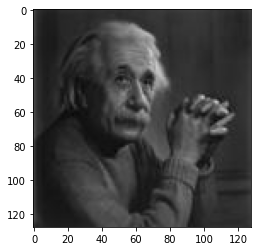

Output Image: 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


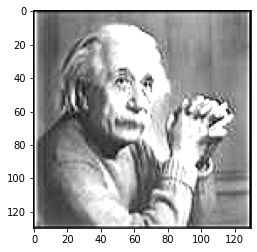

In [43]:
print("Input Image: \n")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print("Output Image: \n")
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.show()

#Comparing the out output with other built in function such as scipy.signal.convolve2d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output Image: 



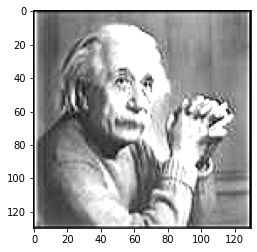

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Using convolve2D: 



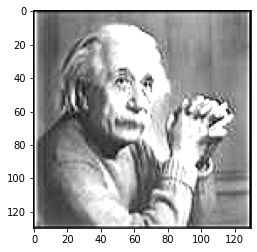

In [44]:
print("Output Image: \n")
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.show()
from scipy import signal
result = signal.convolve2d(img, kernel, "full")/255
print("Using convolve2D: \n")
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()
# result = cv2.filter2D(img, -1, kernel)
# print(result)
# print(result.shape)
# plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
# plt.show()

In [ ]:
I = np.array([[1,2,3],
             [4,5,6]])
F = np.array([[10,20],
              [30,40]])

In [ ]:
I_row_num, I_col_num = I.shape
F_row_num, F_col_num = F.shape

output_row_num = I_row_num + F_row_num-1
output_col_num = I_col_num + F_col_num-1
output_shape = output_row_num, output_col_num


In [ ]:
F_zero_padded = np.pad(F, ((output_row_num-F_row_num, 0),
                           (0,output_col_num-F_col_num)),
                       'constant', constant_values=0)
print(F_zero_padded)

[[ 0  0  0  0]
 [10 20  0  0]
 [30 40  0  0]]


In [ ]:
import scipy.linalg as sl
toeplitz_list = []
for i in range(F_zero_padded.shape[0]-1, -1,-1):
  c = F_zero_padded[i,:];
  r = np.r_[c[0], np.zeros(I_col_num-1)]
  toeplitz_m = sl.toeplitz(c,r)
  toeplitz_list.append(toeplitz_m)
  # print('C: '+str(i),c)
  # print('R: '+str(i),r)
  # print('M: '+str(i),'\n',toeplitz_m, '\n')
  # print(toeplitz_m.shape)


In [ ]:
c = range(1, F_zero_padded.shape[0]+1)
r = np.r_[c[0], np.zeros(I_row_num-1, dtype=int)]
doubly_indices = sl.toeplitz(c,r)
print(c)
print(r)
print('Doubly Indices\n' , doubly_indices)

range(1, 4)
[1 0]
Doubly Indices
 [[1 0]
 [2 1]
 [3 2]]


In [ ]:
#shape of one of those small toeplitz matrices
h = toeplitz_list[0].shape[0]*doubly_indices.shape[0]
w = toeplitz_list[0].shape[1]*doubly_indices.shape[1]
doubly_blocked_shape = [h, w]
doubly_blocked = np.zeros(doubly_blocked_shape)


In [ ]:
#Tile the toeplitz matrix
b_h, b_w = toeplitz_list[0].shape
for i in range(doubly_indices.shape[0]):
  for j in range(doubly_indices.shape[1]):
    start_i = i*b_h
    start_j = j*b_w
    end_i  = start_i + b_h
    end_j = start_j + b_w
    doubly_blocked[start_i: end_i, start_j: end_j]=toeplitz_list[doubly_indices[i,j]-1]
print(doubly_blocked)
print(doubly_blocked.shape)

[[30.  0.  0.  0.  0.  0.]
 [40. 30.  0.  0.  0.  0.]
 [ 0. 40. 30.  0.  0.  0.]
 [ 0.  0. 40.  0.  0.  0.]
 [10.  0.  0. 30.  0.  0.]
 [20. 10.  0. 40. 30.  0.]
 [ 0. 20. 10.  0. 40. 30.]
 [ 0.  0. 20.  0.  0. 40.]
 [ 0.  0.  0. 10.  0.  0.]
 [ 0.  0.  0. 20. 10.  0.]
 [ 0.  0.  0.  0. 20. 10.]
 [ 0.  0.  0.  0.  0. 20.]]
(12, 6)


In [ ]:
#input matrix to vector
def matrix_to_vector(input):
  input_h, input_w = input.shape
  output_vector = np.zeros(input_h*input_w, dtype=input.dtype)
  #flip the input matrix upside down
  input = np.flipud(input)
  for i, row in enumerate(input):
    st = i*input_w
    nd = st+input_w
    output_vector[st:nd]=row
  return output_vector
print(matrix_to_vector(I))

[4 5 6 1 2 3]


In [ ]:
#get result of the convolution by matrix multiplication
vectorized_input = matrix_to_vector(I)
print(vectorized_input.shape)
print(vectorized_input)
result_vector = np.matmul(doubly_blocked, vectorized_input)
print("result: ", result_vector)

(6,)
[4 5 6 1 2 3]
result:  [120. 310. 380. 240.  70. 230. 330. 240.  10.  40.  70.  60.]


In [ ]:
#vector_to_matrix
def vector_to_matrix(input, output_shape):
  output_h, output_w = output_shape
  output = np.zeros(output_shape, dtype=input.dtype)
  for i in range(output_h):
    st = i*output_w
    nd = st+output_w
    output[i,:] = input[st:nd]

  #flipping again downup
  output = np.flipud(output)
  return output
out = vector_to_matrix(result_vector,  output_shape)
print(out)

[[ 10.  40.  70.  60.]
 [ 70. 230. 330. 240.]
 [120. 310. 380. 240.]]


In [ ]:
from scipy import signal
result = signal.convolve2d(I, F, "full")
print(result)

[[ 10  40  70  60]
 [ 70 230 330 240]
 [120 310 380 240]]


error: ignored